# Import libraries

In [2]:
import requests
import nltk
import spacy
import tensorflow as tf
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
from tensorflow.keras import utils

# Load data

In [3]:
import requests
import os

# 10.5281/zenodo.17054610
record_id = '17054610'
filename_to_download = 'vk_groups_dataset.xlsx'

api_url = f'https://zenodo.org/api/records/{record_id}'

try:
    print(f"Searching for file '{filename_to_download}' in Zenodo repository with ID: {record_id}...")

    response = requests.get(api_url)
    response.raise_for_status()
    data = response.json()

    file_url = None
    for file in data.get('files', []):
        if file.get('key') == filename_to_download:
            file_url = file.get('links', {}).get('self')
            break

    if file_url:
        print(f"File '{filename_to_download}' found. Starting download...")

        file_response = requests.get(file_url, stream=True)
        file_response.raise_for_status()

        # Save the file to the current directory
        with open(filename_to_download, 'wb') as f:
            for chunk in file_response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"File '{filename_to_download}' downloaded successfully.")
    else:
        print(f"File '{filename_to_download}' not found in the repository.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred while accessing Zenodo: {e}")


groups = pd.read_excel('vk_groups_dataset.xlsx')
groups = groups.dropna()
groups

Searching for file 'vk_groups_dataset.xlsx' in Zenodo repository with ID: 17054610...
File 'vk_groups_dataset.xlsx' found. Starting download...
File 'vk_groups_dataset.xlsx' downloaded successfully.


,ID_группы,Название,ID_города,Город,Описание,Признак
0,177967802,"Мемы, просто мемы©",73.0,Красноярск,Только мемы,0
1,164044699,Дон Корлеоне | Доставка еды в Донецке,8590.0,Донецк,"Доставка вкусных суши, пиццы и роллов в Донецке.",1
2,94593777,Книги Ольги Гучковой - фэнтези,108.0,Орск,Авторская группа писателя Гучковой Ольги. \nВс...,0
3,228450292,ДОСТАВКА ДОМАШНИХ ОБЕДОВ | ПАПА РЯДОМ |,58.0,Ишим,"Мы предоставляем услуги доставки домашней еды,...",1
4,168035552,Додо Пицца Елабуга,50.0,Елабуга,"«Додо Пицца» — международная сеть, которая род...",1
...,...,...,...,...,...,...
11604,210695374,Мемы,55.0,Иваново,Мемы,0
11606,202979643,Sushi Shik | Алчевск | Роллы,5648.0,Алчевск,БЕСПЛАТНАЯ ДОСТАВКА от 1500р\n\nОформляйте зак...,1
11610,228814825,Доставка Kaifa | суши роллы Излучинск,2162.0,Излучинск,"🔹Отправь ""+"" в сообщения и забирай подарок!🔹\n...",1
11611,58188402,Доставка обедов СПБ | Кулинария | Торты,2.0,Санкт-Петербург,"Организация питания групп, обеды в офисе, кейт...",1


# Dividing the data into training and test sets

In [36]:
# auxiliary function of dividing dataframes
def split_dataframe(dataframe, test_proportion):
    total_size = len(dataframe)
    test_size = int(total_size * test_proportion)
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    train_indices = indices[0:total_size-test_size]
    test_indices = indices[total_size - test_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]

In [37]:
train, test = split_dataframe(groups, 0.3)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

We highlight the correct answers




In [38]:
nb_classes = 2
y_train = utils.to_categorical(train["Признак"], nb_classes)

y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

# Tokenization of text

In [39]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils


In [40]:
# number of tokenizer words
num_words = 100000

tokenizer = Tokenizer(num_words=num_words)
names = train['Название']
descrs = train['Описание']

names

,Название
0,МЕМЫ
1,Мемы
2,Новости Кавказа (18+)
3,"БУРГЕРНАЯ №1 | Бургеры, Пицца - Липецк"
4,Мелисса - Пицца и роллы | Бургеры | Первомайский
...,...
5808,ЕДА БЕЗ ВРЕДА
5809,Донбасс | Главные новости
5810,Фотография в Воскресенске
5811,"ВКУСНЯШКА ОТ ""СИРЕНИ"" / Доставка обедов Златоуст"


In [41]:
tokenizer.fit_on_texts(descrs)
tokenizer.word_index

{'и': 1,
 'в': 2,
 'на': 3,
 'с': 4,
 '00': 5,
 'доставка': 6,
 'по': 7,
 'для': 8,
 'от': 9,
 'мы': 10,
 'до': 11,
 'https': 12,
 'не': 13,
 'вы': 14,
 'это': 15,
 'суши': 16,
 '—': 17,
 'или': 18,
 'vk': 19,
 '10': 20,
 'к': 21,
 'роллы': 22,
 'а': 23,
 'у': 24,
 'вас': 25,
 'заказ': 26,
 'ru': 27,
 'доставки': 28,
 '–': 29,
 'com': 30,
 'за': 31,
 'что': 32,
 'только': 33,
 'из': 34,
 'нас': 35,
 '•': 36,
 'вам': 37,
 '7': 38,
 '11': 39,
 'рублей': 40,
 'ул': 41,
 'при': 42,
 '22': 43,
 '8': 44,
 'меню': 45,
 'заказа': 46,
 'все': 47,
 'бесплатная': 48,
 '1': 49,
 'работы': 50,
 'еды': 51,
 'пицца': 52,
 'заказать': 53,
 'о': 54,
 'можно': 55,
 'день': 56,
 '23': 57,
 'блюда': 58,
 '30': 59,
 'г': 60,
 'еда': 61,
 'время': 62,
 'как': 63,
 'мемы': 64,
 'руб': 65,
 'книги': 66,
 'роллов': 67,
 'заказе': 68,
 '2': 69,
 'чтобы': 70,
 'заказы': 71,
 'каждый': 72,
 'наш': 73,
 'можете': 74,
 '✧': 75,
 'если': 76,
 'блюд': 77,
 'так': 78,
 'новости': 79,
 'cc': 80,
 'пиццы': 81,
 'здесь':

# Converting descriptions to numeric representation

In [42]:
sequences = tokenizer.texts_to_sequences(descrs)

index = 15
print(descrs[index])
print(sequences[index])

🙏🏻 Хочется вкусных роллов или пиццы?

👉🏻 Заказывайте доставку еды в "Ай, да Gini"!

😊 Участвуйте в наших акциях и розыгрышах! Получайте подарки за активность в группе!

💌 Подписывайтесь на рассылку и получайте самые выгодные предложения!

🚙 Бесплатная доставка при заказе от 1500₽ в пределах города
При заказе до 1500₽ доставка от 250₽

⏰ Мы работаем для вас
Ежедневно с 10:00 до 22:00

☎ Телефон для заказа
+7(906)-111-08-80

✅ Скидка 10% в подарок к заказу от 800₽ при самовывозе по адресу:
Набережные Челны, ул. Раиса Беляева 25а

Роллы Набережные Челны
Суши Набережные Челны
Пицца Набережные Челны
Доставка роллов Набережные Челны
Доставка суши Набережные Челны
Доставка пиццы Набережные Челны
Доставка еды Набережные Челны
[19230, 595, 453, 67, 18, 81, 899, 511, 89, 51, 2, 19231, 837, 19232, 1943, 3381, 2, 136, 1384, 1, 2805, 1469, 570, 31, 5143, 2, 134, 5144, 535, 3, 2127, 1, 1469, 164, 728, 489, 4672, 48, 6, 42, 68, 9, 1822, 2, 1758, 140, 42, 68, 11, 1822, 6, 9, 3619, 282, 10, 110, 8, 25,

In [43]:
#determining the max length
max = 0
for i in sequences:
  if len(i) > max: max = len(i)
max

548

In [44]:
sequences

[[3610, 184, 64, 64],
 [64, 494, 470],
 [1651,
  1882,
  478,
  19152,
  1,
  9752,
  19153,
  19154,
  1543,
  12770,
  323,
  3169,
  1254,
  19155,
  19156,
  1543,
  12770,
  265,
  2300,
  3,
  2528,
  2,
  472,
  333,
  19157,
  79,
  12771,
  1,
  9753,
  158,
  132,
  5741,
  2125,
  919,
  10,
  524,
  21,
  19158,
  2800,
  1463,
  1223,
  8,
  19159,
  9754,
  86,
  4,
  2801,
  19160,
  2529,
  415,
  21,
  118,
  8,
  1544,
  2967,
  850,
  6629,
  1,
  19161,
  1224,
  7,
  19162,
  12772,
  2413,
  79,
  3889,
  9755,
  375,
  9756,
  19163,
  19164,
  19165,
  19166,
  9757,
  1074,
  7972,
  1074,
  12773,
  19167,
  19168,
  12774,
  19169,
  19170,
  19171,
  19172,
  9758,
  2968,
  9759,
  19173,
  3890,
  3373,
  9760,
  1074,
  19174,
  3611,
  12775,
  19175,
  19176,
  2968,
  19177,
  19178,
  7973,
  12775,
  2657,
  19179],
 [3374,
  17,
  15,
  245,
  151,
  653,
  12776,
  169,
  48,
  6,
  7,
  9761,
  42,
  68,
  9,
  19180,
  65,
  2,
  122,
  45,
  799

We reduce the length of the names to one value

In [45]:
x_train = pad_sequences(sequences, maxlen = max)
x_train

array([[    0,     0,     0, ...,   184,    64,    64],
       [    0,     0,     0, ...,    64,   494,   470],
       [    0,     0,     0, ..., 12775,  2657, 19179],
       ...,
       [    0,     0,     0, ..., 47011,     7, 47012],
       [    0,     0,     0, ...,   116,  1996,   688],
       [    0,     0,     0, ...,     9,   124, 18990]], dtype=int32)

# Convolutional neural network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
model_cnn = Sequential()
model_cnn.add(Embedding(100, 32, input_length=max))
model_cnn.add(Conv1D(350, 8, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Creating Callback

In [48]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=15,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6877 - loss: 0.5849
Epoch 1: val_accuracy improved from -inf to 0.92440, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.6903 - loss: 0.5818 - val_accuracy: 0.9244 - val_loss: 0.2334
Epoch 2/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9325 - loss: 0.2135
Epoch 2: val_accuracy improved from 0.92440 to 0.94502, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9327 - loss: 0.2129 - val_accuracy: 0.9450 - val_loss: 0.1720
Epoch 3/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9423 - loss: 0.1805
Epoch 3: val_accuracy did not improve from 0.94502
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9424 - loss: 0.1798 - val_accuracy: 0.9450 - val_loss: 0.1554
Epoch 4/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9492 - loss: 0.1490
Epoch 4: val_accuracy improved from 0.94502 to 0.94674, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9491 - loss: 0.1490 - val_accuracy: 0.9467 - val_loss: 0.1413
Epoch 5/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9540 - loss: 0.1333
Epoch 5: val_accuracy improved from 0.94674 to 0.94845, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9539 - loss: 0.1334 - val_accuracy: 0.9485 - val_loss: 0.1366
Epoch 6/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9607 - loss: 0.1133
Epoch 6: val_accuracy did not improve from 0.94845
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9604 - loss: 0.1139 - val_accuracy: 0.9467 - val_loss: 0.1283
Epoch 7/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9568 - loss: 0.1219
Epoch 7: val_accuracy did not improve from 0.94845
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9567 - loss: 0.1220 - val_accuracy: 0.9433 - val_loss: 0.1333
Epoch 8/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9556 - loss: 0.1188
Epoch 8: val_accuracy improved from 0.94845 to 0.95017, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9556 - loss: 0.1188 - val_accuracy: 0.9502 - val_loss: 0.1352
Epoch 9/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9578 - loss: 0.1157
Epoch 9: val_accuracy did not improve from 0.95017
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9578 - loss: 0.1158 - val_accuracy: 0.9467 - val_loss: 0.1378
Epoch 10/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9601 - loss: 0.1122
Epoch 10: val_accuracy improved from 0.95017 to 0.95533, saving model to best_model_cnn.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9600 - loss: 0.1123 - val_accuracy: 0.9553 - val_loss: 0.1372
Epoch 11/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9663 - loss: 0.0980
Epoch 11: val_accuracy did not improve from 0.95533
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9660 - loss: 0.0985 - val_accuracy: 0.9485 - val_loss: 0.1461
Epoch 12/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9675 - loss: 0.1014
Epoch 12: val_accuracy did not improve from 0.95533
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9673 - loss: 0.1017 - val_accuracy: 0.9347 - val_loss: 0.1595
Epoch 13/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9633 - loss: 0.1070
Epoch 13: val_accuracy did not improve from 0.95533
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9633 - loss: 0.1069 - val_accuracy: 0.9485 - val_loss: 0.1455
Epoch 14/15
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9651 - loss: 0.0950
Epoch 14: val_accuracy did not impro

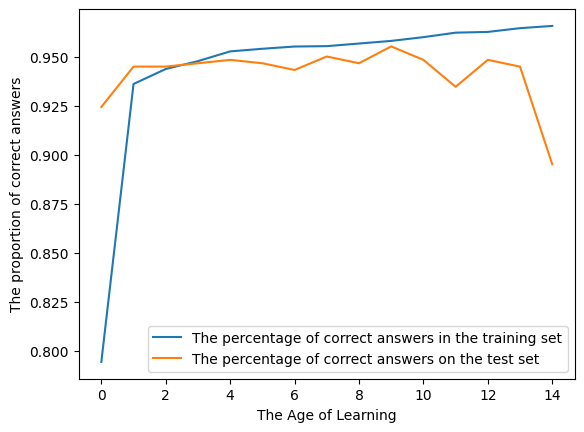

In [49]:
plt.plot(history_cnn.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_cnn.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Recurrent LSTM network

In [50]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(2, activation='softmax'))

model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_lstm = model_lstm.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6338 - loss: 0.6559
Epoch 1: val_accuracy improved from -inf to 0.76460, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6363 - loss: 0.6534 - val_accuracy: 0.7646 - val_loss: 0.4656
Epoch 2/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8432 - loss: 0.3544
Epoch 2: val_accuracy improved from 0.76460 to 0.94502, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8455 - loss: 0.3508 - val_accuracy: 0.9450 - val_loss: 0.1978
Epoch 3/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9681 - loss: 0.1160
Epoch 3: val_accuracy improved from 0.94502 to 0.97251, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9684 - loss: 0.1149 - val_accuracy: 0.9725 - val_loss: 0.0825
Epoch 4/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9879 - loss: 0.0461
Epoch 4: val_accuracy improved from 0.97251 to 0.97423, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9879 - loss: 0.0459 - val_accuracy: 0.9742 - val_loss: 0.0807
Epoch 5/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9957 - loss: 0.0233
Epoch 5: val_accuracy improved from 0.97423 to 0.98282, saving model to best_model_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9956 - loss: 0.0233 - val_accuracy: 0.9828 - val_loss: 0.0513


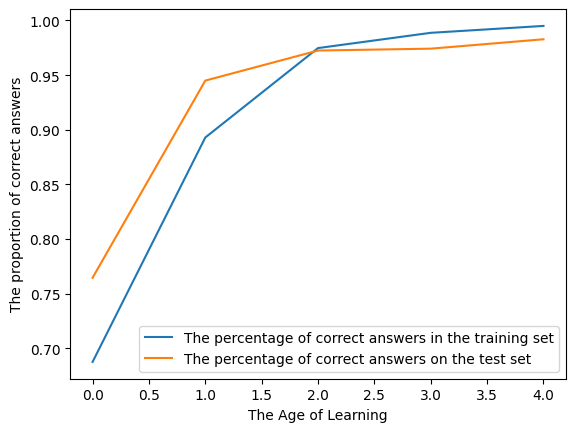

In [52]:
plt.plot(history_lstm.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_lstm.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Recurrent GRU network

In [53]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max))
model_gru.add(GRU(16))
model_gru.add(Dense(2, activation='softmax'))

model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_gru.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
history_gru = model_gru.fit(x_train,
                              y_train,
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6146 - loss: 0.6703
Epoch 1: val_accuracy improved from -inf to 0.69072, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6152 - loss: 0.6696 - val_accuracy: 0.6907 - val_loss: 0.5448
Epoch 2/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7846 - loss: 0.4409
Epoch 2: val_accuracy improved from 0.69072 to 0.91753, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7877 - loss: 0.4365 - val_accuracy: 0.9175 - val_loss: 0.2391
Epoch 3/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9517 - loss: 0.1416
Epoch 3: val_accuracy improved from 0.91753 to 0.96392, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9522 - loss: 0.1405 - val_accuracy: 0.9639 - val_loss: 0.1299
Epoch 4/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9773 - loss: 0.0696
Epoch 4: val_accuracy did not improve from 0.96392
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9774 - loss: 0.0696 - val_accuracy: 0.9553 - val_loss: 0.1277
Epoch 5/5
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9900 - loss: 0.0413
Epoch 5: val_accuracy improved from 0.96392 to 0.97079, saving model to best_model_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9900 - loss: 0.0411 - val_accuracy: 0.9708 - val_loss: 0.1013


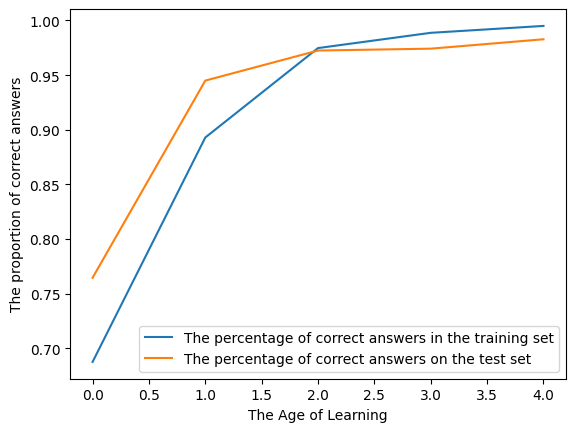

In [55]:
plt.plot(history_gru.history['accuracy'],
         label='The percentage of correct answers in the training set')
plt.plot(history_gru.history['val_accuracy'],
         label='The percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('The proportion of correct answers')
plt.legend()
plt.show()

# Checking on the testing set

In [56]:
test

,ID_группы,Название,ID_города,Город,Описание,Признак
0,220120354,Домашняя еда!,42.0,Воронеж,Хочется вкусной еды по домашнему?\nС удовольст...,1
1,197983177,Fish'ka Димитровград доставка | Роллы | Фишка,476.0,Димитровград,Доставка еды по г.Димитровград\nНаши цены и ка...,1
2,226667583,Новости зрителей!,1.0,Москва,"Горячие новости, происшествия, события из реги...",0
3,229374928,"КУДЗИРА | СУШИ, РОЛЛЫ | СТАРЫЙ ОСКОЛ",274.0,Старый Оскол,🥱Устали от однообразных роллов? Хочется сочног...,1
4,73779327,Семейный спортивный магазин АВТ - Спорт,110.0,Пермь,Присоединяйся к спорту вместе с нами!,0
...,...,...,...,...,...,...
2486,231758160,Суши Ким Старотитаровкая,4670.0,Хадыженск,🔥Высокое качество по приятным ценам\n🍱РОЛЛЫ\n🍕...,1
2487,161141253,Еда на Да - продукты для здоровья,109.0,Пенза,Бренд «ЕДА на ДА» существует на рынке с 2016 г...,1
2488,70704592,"Мама-Сан | Доставка еды: роллы, пицца. Мурманск",87.0,Мурманск,"""Мама-Сан"" - служба доставки вкусной еды на до...",1
2489,35497102,"Доставка обедов ""Черешня"". Минск",282.0,Минск,Добро Пожаловать!\n\n«Черешня» - ресторан дост...,1


In [57]:
test_sequences = tokenizer.texts_to_sequences(test['Описание'])
x_test = pad_sequences(test_sequences, maxlen=max)
x_test

array([[    0,     0,     0, ...,   500,     7,    97],
       [    0,     0,     0, ...,    11,   103,    59],
       [    0,     0,     0, ...,    19,    30, 13409],
       ...,
       [    0,     0,     0, ...,    11,    43,   220],
       [    0,     0,     0, ...,   368,     1,   368],
       [    0,     0,     0, ...,   142,    93,   181]], dtype=int32)

In [58]:
y_test = utils.to_categorical(test['Признак'], nb_classes)
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

# We evaluate the quality of the networks on the test set

One-dimensional convolutional network

In [59]:
model_cnn.load_weights(model_cnn_save_path)
model_cnn.evaluate(x_test, y_test, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9384 - loss: 0.1772


[0.17233699560165405, 0.9385789036750793]

Recurrent LSTM Network

In [60]:
model_lstm.load_weights(model_lstm_save_path)
model_lstm.evaluate(x_test, y_test, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9785 - loss: 0.0783


[0.07145950943231583, 0.9807306528091431]

The GRU Recurrent Network

In [61]:
model_gru.load_weights(model_gru_save_path)
model_gru.evaluate(x_test, y_test, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9648 - loss: 0.1139


[0.10302040725946426, 0.966278612613678]